In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

import matplotlib.pyplot as plt
data = np.loadtxt('data/credit-data.csv', dtype=np.int, delimiter=',', skiprows=1)
X, y = data[:, 1:-1], data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

D:\Users\Jesus\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [61]:
"""
normalize the money , too big
change shape of y_train,y_test, maintain consistency shape of (num_category, num_example)
"""

'\nnormalize the money , too big\nchange shape of y_train,y_test, maintain consistency shape of (T/F, num_example)\n'

In [2]:
#accustumed to working with dim: (num_features, num_examples)
y_train = y_train.reshape(-1,1).T
y_test = y_test.reshape(-1,1).T

X_train = X_train.T
X_test = X_test.T

In [18]:
#layer_dims: array of int of dim [dim_(i-1), dim_i ....]
def init_params(layer_dims):
    parameters = {}
    for i in range(1, len(layer_dims)):
        W = tf.get_variable("W" + str(i), [layer_dims[i],layer_dims[i-1]], initializer = tf.contrib.layers.xavier_initializer())
        b = tf.get_variable("b" + str(i), [layer_dims[i],1], initializer = tf.contrib.layers.xavier_initializer())
        
        parameters["W" + str(i) ] =  W
        parameters["b" + str(i) ] =  b                       
    return parameters
    

In [19]:
def create_placeholder(nx,ny):
    X = tf.placeholder(tf.float32, shape = (nx,None), name = "X")
    Y = tf.placeholder(tf.float32, shape = (ny, None), name = "Y")
    
    return X,Y

In [30]:
tf.reset_default_graph()

with tf.Session() as sess:

    params = parameters = init_params([12288,25,12,6])
    
    for key,val in params.items():
        print("{} = {}".format(key, val))


W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>


In [178]:
def forward_prop(X,params):
    Z = tf.add(tf.matmul(params["W1"],X), params["b1"])
    A = tf.nn.relu(Z)
    
    for i in range(2, len(params)//2+1):
        Z = tf.add(tf.matmul(params["W" + str(i)], A), params["b" + str(i)])
        A = tf.nn.sigmoid(Z)
    
    return Z

In [8]:
tf.reset_default_graph()
with tf.Session() as sess:
    X = tf.placeholder(tf.float32, shape = [12288, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [6, None], name = "X")
    parameters = init_params([12288,25,12,6])
    Z = forward_prop(X,parameters)
    print("Z = " + str(Z))

Z = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


In [64]:
def calc_cost(out,Y):
    labels = tf.transpose(Y)
    logits = tf.transpose(out)
    
    #labels = Y
    #logits = out

    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [10]:
tf.reset_default_graph()

with tf.Session() as sess:
    X = tf.placeholder(tf.float32, shape = [12288, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [6, None], name = "X")
    params = parameters = init_params([12288,25,12,6])
    out = forward_prop(X,params)
    cost = calc_cost(out,Y)
    print(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Tensor("Mean:0", shape=(), dtype=float32)


In [35]:
#Yshape: (num category , num example)
def rand_mini_batches(X,Y, size = 64):
    m = X.shape[1]
    mini_batches = []
    
    perm = list(np.random.permutation(m))
    shuffX = X[:,perm]
    shuffY = Y[:,perm].reshape((Y.shape[0],m))
    
    num_complete_batch = m//size
    
    for i in range(0,num_complete_batch):
        minX = shuffX[:,i * size : i * size + size]
        minY = shuffY[:,i * size : i * size + size]
        minBatch = (minX,minY)
        
        mini_batches.append(minBatch)
    
    if(m%size !=0):
        minX = shuffX[:, num_complete_batch * size : m]
        minY = shuffY[:, num_complete_batch * size : m]
        minBatch = (minX,minY)
        
        mini_batches.append(minBatch)
        
    return mini_batches
        

In [146]:
def model(X_train, Y_train,X_test,Y_test, layer_dims, learning_rate = 0.0001, num_epochs = 1500, minibatch_size = 32,print_cost = True):
    
    ops.reset_default_graph()
    (nx, m) = X_train.shape
    ny = Y_train.shape[0]
    costs = []

    
    X,Y = create_placeholder(nx,ny)
    params = init_params(layer_dims)
    
    #forward propagate the thing
    out = forward_prop(X, params)
    
    cost = calc_cost(out,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0
            
            num_minbatch = int(m/minibatch_size)
            
            minibatches = rand_mini_batches(X_train,Y_train, num_minbatch)
            
            for minibatch in minibatches:
                
                (minX,minY) = minibatch
                
                _, minBatchCost = sess.run([optimizer,cost], feed_dict = {X:minX, Y:minY})
                
                epoch_cost += minBatchCost / num_minbatch 
                
            
            if print_cost == True and epoch % 100 == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
            
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
            
        
        plt.plot(np.squeeze(costs))
        plt.ylabel("cost")
        plt.xlabel("iterations (per tens)")
        plt.title("learning rate = " + str(learning_rate))
        plt.show()
        
        params = sess.run(params)
        
        """ 
        correct = tf.equal(tf.round(out), Y)
        
        accuracy = tf.reduce_mean(tf.cast(correct,"float"))
        
        print("train accuracy: " , accuracy.eval({X:X_train, Y: Y_train}))
        print("test accuracy: " , accuracy.eval({X:X_test, Y: Y_test}))
        
        out = sess.run(out, feed_dict = {X: X_train})
        """
        return params, out

In [179]:
numuse = X_train.shape[1]

X_use = X_train[:, 0:numuse]
Y_use = y_train[:, 0:numuse]


Cost after epoch 0: 0.043678
Cost after epoch 100: 0.024920
Cost after epoch 200: 0.024791
Cost after epoch 300: 0.024628
Cost after epoch 400: 0.024949
Cost after epoch 500: 0.023964
Cost after epoch 600: 0.024254
Cost after epoch 700: 0.024232
Cost after epoch 800: 0.024179
Cost after epoch 900: 0.025011
Cost after epoch 1000: 0.023890
Cost after epoch 1100: 0.023873
Cost after epoch 1200: 0.024227
Cost after epoch 1300: 0.024829
Cost after epoch 1400: 0.024186


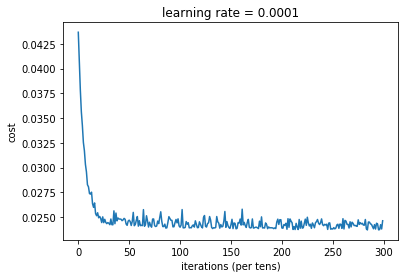

train accuracy:  0.060355555
test accuracy:  0.0636


In [180]:
layer_dims = [X_train.shape[0],18,10,1]
params, out1 = model(X_use,Y_use, X_test,y_test,layer_dims)

In [181]:
def check(params, X):
    Z = np.add(np.matmul(params["W1"],X), params["b1"])
    A = np.maximum(0,Z)
    for i in range(2, len(params)//2 + 1):
        Z = np.add(np.matmul(params["W" + str(i)], A), params["b" + str(i)])
        A = np.maximum(0,Z)
   
    return A

In [182]:
out2 = check(params, X_test)
ans = out2 == y_test
n = np.sum(ans)
n/7500

0.7830666666666667

In [183]:
for i in range(7500):
    if(out2[0,i] != 0):
        print(i)
    
print("done")

done


In [175]:
out2[0,2899]

952.3901647188659

In [184]:
p = np.sum(y_train)

In [185]:
p

5009